In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/DeepLearning/Covid19/dataset
cp = '/content/gdrive/MyDrive/DeepLearning/Covid19/dataset'

all  part


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_all_origin = pd.read_csv(cp + '/all/covid19_20210418_all.csv')
data_part_origin = pd.read_csv(cp + '/part/covid19_20210418_part.csv')

In [ ]:
data_all = data_all_origin.drop(['Unnamed: 0'], axis = 1)
data_part = data_part_origin.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_all

#   속성 설명(all)
#   DECIDE_CNT          누적 확진자수
#   CLEAR_CNT           누적 격리해제 수
#   EXAM_CNT            검사진행 수
#   DEATH_CNT           누적 사망자 수
#   CARE_CNT            치료중 환자 수
#   RESULT_NEG_CNT      결과 음성 수
#   ACC_EXAM_CNT        누적 검사 수
#   ACC_EXAM_COMP_CNT   누적 검사 완료 수
#   ACC_DEF_RATE        누적 확진률
#   CREATE_DT           등록일시분초
#   UPDATE_DT           수정일시분

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,NaN,NaN,NaN,NaN,1,47:33.3,0,0,1,NaN,1,20200101,18:00,21:56.6
1,NaN,NaN,NaN,NaN,1,47:33.3,0,0,1,NaN,1,20200201,18:00,47:33.3
2,NaN,NaN,NaN,NaN,2,22:49.5,2,2,2,NaN,2,20200202,9:00,22:49.5
3,NaN,NaN,NaN,NaN,0,41:17.2,0,15,0,NaN,3,20200203,9:00,41:17.2
4,NaN,NaN,NaN,NaN,0,26:59.6,0,0,0,NaN,4,20200204,0:00,26:59.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,1.363619,8245387.0,8170760.0,7653.0,101983,2021-04-14 09:33:58.653,1782,111418,74627,8059342.0,480,20210414,00:00,2021-04-16 15:24:52.012
440,1.363792,8291125.0,8220904.0,7815.0,102513,2021-04-15 09:38:50.34,1788,112116,70221,8108788.0,481,20210415,00:00,2021-04-16 09:32:37.708
441,1.365080,8333332.0,8262449.0,7937.0,103062,2021-04-16 09:32:10.738,1790,112789,70883,8149660.0,482,20210416,00:00,NaN
442,1.365674,8377778.0,8306739.0,8055.0,103594,2021-04-17 09:40:16.606,1794,113443,71039,8193296.0,483,20210417,00:00,2021-04-18 09:35:59.415


In [ ]:
data_all = data_all.drop(['createDt', 'updateDt', 'seq', 'stateTime'], axis = 1)

infector = []
clear = []
infector.append(0)
clear.append(0)

for i in range(len(data_all) - 1):
    infector.append(data_all['decideCnt'][i + 1] - data_all['decideCnt'][i])
    clear.append(data_all['clearCnt'][i + 1] - data_all['clearCnt'][i])

infector = np.array(infector)
clear = np.array(clear)
infector = pd.DataFrame(infector)
clear = pd.DataFrame(clear)
infector.columns = ['infector']
clear.columns = ['clear']

data_all = data_all.assign(infector = infector)
data_all = data_all.assign(clear = clear)
data_all = data_all.dropna()
data_all = data_all.reset_index(drop = True)

data_all

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,deathCnt,decideCnt,examCnt,resutlNegCnt,stateDt,infector,clear
0,5.329140,125851.0,90296.0,4159.0,34,28,4812,35555,85484.0,20200303,600,3
1,4.919986,136707.0,108293.0,4750.0,41,32,5328,28414,102965.0,20200304,516,7
2,4.622748,146541.0,124731.0,5255.0,88,35,5766,21810,118965.0,20200305,438,47
3,4.397235,164740.0,142908.0,5643.0,108,42,6284,21832,136624.0,20200306,518,20
4,4.267543,178189.0,158569.0,6134.0,118,44,6767,19620,151802.0,20200307,483,10
...,...,...,...,...,...,...,...,...,...,...,...,...
407,1.363619,8245387.0,8170760.0,7653.0,101983,1782,111418,74627,8059342.0,20210414,731,651
408,1.363792,8291125.0,8220904.0,7815.0,102513,1788,112116,70221,8108788.0,20210415,698,530
409,1.365080,8333332.0,8262449.0,7937.0,103062,1790,112789,70883,8149660.0,20210416,673,549
410,1.365674,8377778.0,8306739.0,8055.0,103594,1794,113443,71039,8193296.0,20210417,654,532


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_combine = MinMaxScaler()
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

scale_combine_all = ['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt', 'infector']
scale_train_all = ['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt']
scale_test_all = ['infector']

scaled_combine_all = scaler_combine.fit_transform(data_all[scale_combine_all])
scaled_train_all = scaler_train.fit_transform(data_all[scale_train_all])
scaled_test_all = scaler_test.fit_transform(data_all[scale_test_all])

scaled_combine_all = pd.DataFrame(scaled_combine_all)
scaled_train_all = pd.DataFrame(scaled_train_all)
scaled_test_all = pd.DataFrame(scaled_test_all)

scaled_combine_all.columns = scale_combine_all
scaled_train_all.columns = scale_train_all
scaled_test_all.columns = scale_test_all

In [ ]:
#train_all = scaled_combine_all[:len(scaled_combine_all) - 30]
#test_all = scaled_combine_all[len(scaled_combine_all) - 30:]
train_all = scaled_combine_all
test_all = scaled_combine_all

In [ ]:
# make dataset
# find next 'end' data 
def make_dataset(data, label, window_size = 10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)
# dataset: (i ~ i + window_size)days feature_list and (i + window_size) label_list

In [ ]:
train_feature_all = train_all[['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt']]
train_label_all = train_all[['infector']]
test_feature_all = test_all[['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt']]
test_label_all = test_all[['infector']]

In [ ]:
# train dataset
train_feature_all, train_label_all = make_dataset(train_feature_all, train_label_all, 10)

train_feature_all.shape, train_label_all.shape

((402, 10, 4), (402, 1))

In [ ]:
# test dataset
test_feature_all, test_label_all = make_dataset(test_feature_all, test_label_all, 10)

test_feature_all.shape, test_label_all.shape

((402, 10, 4), (402, 1))

In [ ]:
from sklearn.model_selection import train_test_split

# build train, validation set
x_train, x_valid, y_train, y_valid = train_test_split(train_feature_all, train_label_all, test_size = 0.2)

x_train.shape, x_valid.shape

((321, 10, 4), (81, 10, 4))

In [ ]:
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint


def build_model():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, return_sequences = True), input_shape=(train_feature_all.shape[1], train_feature_all.shape[2])))
    model.add(Bidirectional(LSTM(32, return_sequences = False)))
    model.add(Dense(1, activation = 'linear'))

    return model

model = build_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_52 (Bidirectio (None, 10, 128)           35328     
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 76,609
Trainable params: 76,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# if val_loss will not imporve consecutive 10 times(patience = 10), epochs will be stopped
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('check.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax

model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.05), metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 1000, batch_size = 1, validation_data = (x_valid, y_valid), callbacks = [es, mc])

Epoch 1/1000
321/321 [==============================] - 10s 14ms/step - loss: 0.0305 - acc: 0.0023 - val_loss: 0.0164 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to check.h5
Epoch 2/1000
321/321 [==============================] - 3s 9ms/step - loss: 0.0219 - acc: 0.0214 - val_loss: 0.0175 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/1000
321/321 [==============================] - 3s 10ms/step - loss: 0.0184 - acc: 0.0044 - val_loss: 0.0193 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/1000
321/321 [==============================] - 3s 9ms/step - loss: 0.0217 - acc: 0.0068 - val_loss: 0.0177 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/1000
321/321 [==============================] - 3s 9ms/step - loss: 0.0191 - acc: 0.0033 - val_loss: 0.0174 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.00000
Epoch 6/1000
321/321 [===

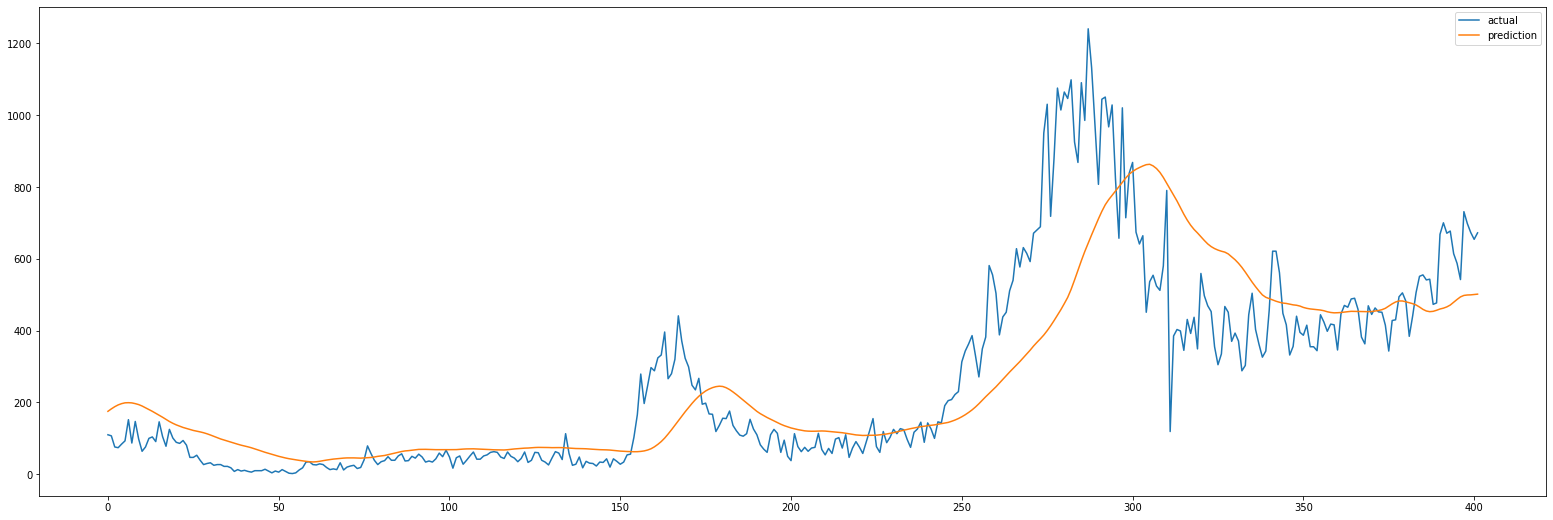

In [ ]:
import matplotlib.pyplot as plt

# loading weight
model.load_weights('check.h5')

# prediction
pred_all = model.predict(test_feature_all)

inverse_test_label_all = scaler_test.inverse_transform(test_label_all)
inverse_test_label_all = pd.DataFrame(inverse_test_label_all)

inverse_pred_all = scaler_test.inverse_transform(pred_all)
inverse_pred_all = pd.DataFrame(inverse_pred_all)

plt.figure(figsize = (27, 9))
plt.plot(inverse_test_label_all, label = 'actual')
plt.plot(inverse_pred_all, label = 'prediction')
plt.legend()
plt.show()

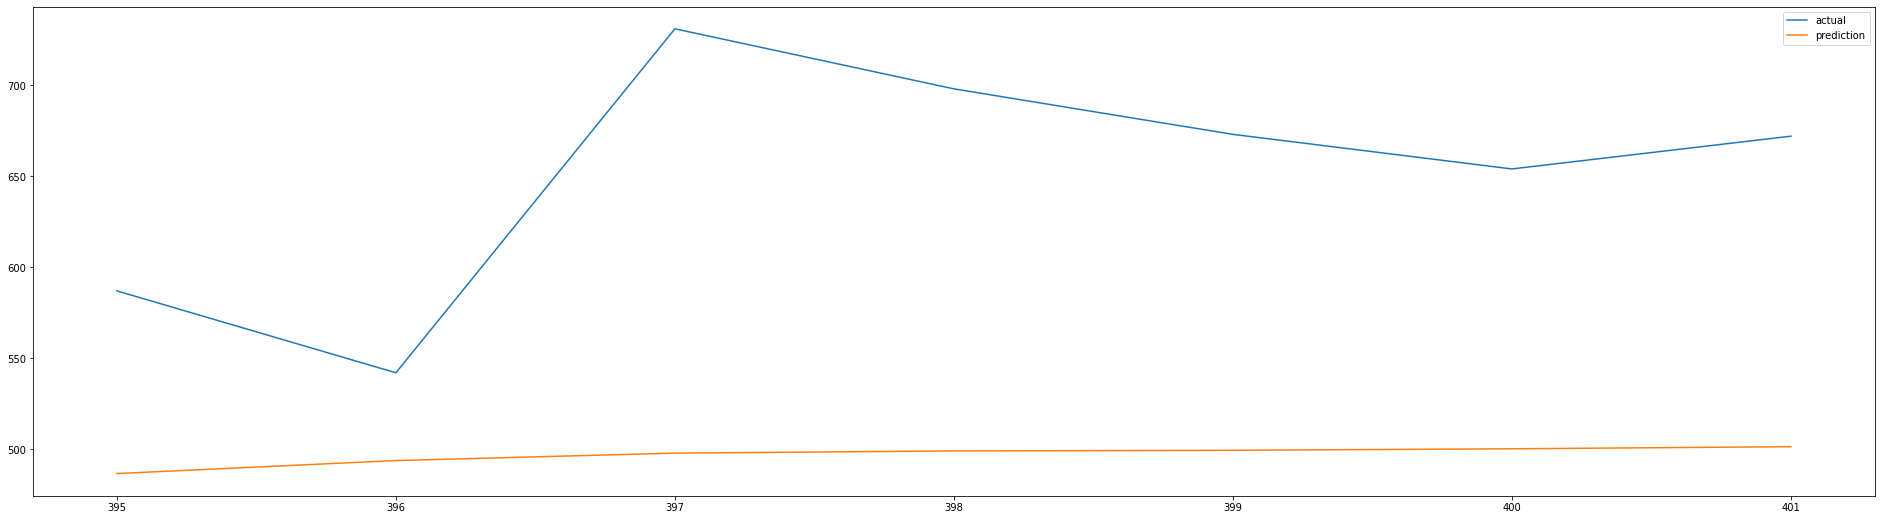

In [ ]:
plt.figure(figsize = (33, 9))
plt.plot(inverse_test_label_all[len(inverse_test_label_all) - 7:], label = 'actual')
plt.plot(inverse_pred_all[len(inverse_pred_all) - 7:], label = 'prediction')
plt.legend()
plt.show()